---
title: "Pandas Deep Dive: Advanced Data Analysis with Music Data"
subtitle: "Master's in Business Data Science"
author: "Roman Jurowetzki"
---

## 🎯 Welcome! Let's Go Beyond the Basics

You've mastered the fundamentals of pandas. Now, it's time to transition from executing commands to conducting a thoughtful, professional analysis. Real-world data is messy, and insights are rarely on the surface—they must be sculpted.

In this session, we'll analyze a rich dataset of Spotify songs. Our work will be guided by a central question: **How has the "sound" of popular music changed over time?** We'll investigate trends like the infamous "Loudness War," explore the anatomy of a hit song, and learn to handle data with the rigor expected of a professional data scientist.

**Our Goal:** To move beyond mechanics and into strategy, learning to clean, transform, and analyze data with purpose and professional rigor.

In [ ]:
# Standard imports for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional plot style
sns.set_theme(style="whitegrid")

# Load our dataset
url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv'
df_raw = pd.read_csv(url)

print("Spotify dataset loaded successfully!")

Spotify dataset loaded successfully!


::: {.callout-note}
#### Understanding Our Dataset
This dataset is from the TidyTuesday project and contains data for songs featured in various Spotify playlists. While it includes many "top hits," it's not a direct representation of an official chart like the Billboard Hot 100. It's a broad sample of popular music, making it excellent for exploring general trends.
:::

---

# Part 1: Professional Data Preparation (25 mins)

A robust analysis is built on a foundation of clean, well-understood data. Our first step is to establish a professional preparation pipeline.

## 1.1 Column Cleaning and Renaming

Raw column names are often inconsistent. We'll standardize them to a `snake_case` format for easy access and programmatic use.

In [ ]:
# Create a working copy to preserve the original raw data
df = df_raw.copy()

# Programmatically clean column names
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')

# Rename key columns for clarity and brevity
rename_dict = {
    'track_name': 'title',
    'track_artist': 'artist',
    'track_popularity': 'popularity',
    'track_album_name': 'album',
    'playlist_genre': 'genre',
    'track_album_release_date': 'release_date'
}
df.rename(columns=rename_dict, inplace=True)

print("Cleaned column names:")
print(df.columns)

Cleaned column names:
Index(['track_id', 'title', 'artist', 'popularity', 'track_album_id', 'album',
       'release_date', 'playlist_name', 'playlist_id', 'genre',
       'playlist_subgenre', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms'],
      dtype='object')


## 1.2 Data Type Conversion: The Importance of Dates

The `release_date` column is a string (`object`), which is useless for time-based analysis. We must convert it to a proper `datetime` format.

In [ ]:
# Convert release_date to datetime objects. `errors='coerce'` is a crucial argument.
# It gracefully handles any un-parseable dates by turning them into NaT (Not a Time).
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Now, we can easily and reliably extract the year
df['year'] = df['release_date'].dt.year

# Let's verify the impact of our error handling
print("Missing values before and after date conversion:")
print(f"Original missing dates: {df_raw['track_album_release_date'].isnull().sum()}")
print(f"Current missing dates (incl. parsing errors): {df['release_date'].isnull().sum()}")

Missing values before and after date conversion:
Original missing dates: 0
Current missing dates (incl. parsing errors): 1886


::: {.callout-important}
#### Professional Error Handling
The number of missing dates *increased*. This is not a mistake; it's a success! Our `errors='coerce'` strategy identified malformed dates (e.g., "1999-XX-XX") in the raw data and correctly flagged them as missing. This prevents future errors and makes our dataset more robust.
:::

## 1.3 Deduplication and Advanced Selection

With clean columns and types, we can finalize our cleaning and use an EDA-informed approach for selection.

In [ ]:
# Drop duplicates based on the essential song identifiers
df.drop_duplicates(subset=['title', 'artist', 'album'], inplace=True, keep='first')

# Let's use EDA to define "high energy" instead of using a magic number
print(df[['energy', 'danceability']].describe())

             energy  danceability
count  27574.000000  27574.000000
mean       0.697587      0.653274
std        0.183911      0.146012
min        0.000175      0.000000
25%        0.578000      0.561000
50%        0.721000      0.670000
75%        0.843000      0.760000
max        1.000000      0.983000


**Insight:** The 75th percentile for `energy` is `0.843` and for `danceability` is `0.76`. Using these as data-driven thresholds for "high" is a justifiable choice. We'll use `0.8` and `0.75` as clean, rounded cutoffs.

In [ ]:
# Scenario: Find all high-energy (energy > 0.8) pop songs (playlist_genre == 'pop') that are also highly danceable (danceability > 0.7).

# Using complex boolean masks with parentheses for clarity
high_energy_pop_hits = df[
    (df['energy'] > 0.8) & 
    (df['genre'] == 'pop') & 
    (df['danceability'] > 0.75)
]

high_energy_pop_hits[['title', 'artist', 'energy', 'danceability', 'genre']].head()

,title,artist,energy,danceability,genre
15,South of the Border (feat. Camila Cabello & Ca...,Ed Sheeran,0.835,0.805,pop
36,Happier - Matt Medved Remix,Marshmello,0.833,0.816,pop
44,Freaking Me Out - Keanu Silva Remix,Ava Max,0.931,0.755,pop
46,When It Comes To You - Benny Benassi & BB Team...,Sean Paul,0.893,0.789,pop
58,Loco Contigo (with J. Balvin & Tyga) - Cedric ...,DJ Snake,0.840,0.752,pop


In [ ]:
# Use the .query() method for a clean, readable filter
high_energy_pop_hits = df.query(
    "energy > 0.8 and genre == 'pop' and danceability > 0.75"
)
high_energy_pop_hits[['title', 'artist', 'energy', 'danceability']].head()

,title,artist,energy,danceability
15,South of the Border (feat. Camila Cabello & Ca...,Ed Sheeran,0.835,0.805
36,Happier - Matt Medved Remix,Marshmello,0.833,0.816
44,Freaking Me Out - Keanu Silva Remix,Ava Max,0.931,0.755
46,When It Comes To You - Benny Benassi & BB Team...,Sean Paul,0.893,0.789
58,Loco Contigo (with J. Balvin & Tyga) - Cedric ...,DJ Snake,0.840,0.752


::: {.callout-tip}
#### When to use `.query()`
The `.query()` method provides a SQL-like string-based syntax for filtering. It is especially readable for complex, multi-condition filters and can offer performance benefits on very large DataFrames.
:::

---

# Part 2: Feature Engineering & Transformation (25 mins)

To ask sophisticated questions, we need sophisticated features. This involves cleaning text, creating new metrics, and merging aggregated data back into our main dataset.

## 2.1 Practical String Operations with `.str`

Text data is often messy. The `.str` accessor is our primary tool for cleaning it.

**Scenario:** The `artist` column contains collaborations. Let's extract the primary artist and create a collaboration flag.

In [ ]:
# Use .str.split() to break the artist string at common delimiters. `expand=True` creates new columns.
artist_split = df['artist'].str.split('; | & ', expand=True)

# The primary artist is the first name in the list
df['primary_artist'] = artist_split[0]

# A collaboration exists if there's a name in the second column
df['is_collaboration'] = artist_split[1].notna()

df[['artist', 'primary_artist', 'is_collaboration']].query("is_collaboration == True").sample(5)

,artist,primary_artist,is_collaboration
24244,Heavy D & The Boyz,Heavy D,True
13890,Captain Beefheart & His Magic Band,Captain Beefheart,True
29565,Darius & Finlay,Darius,True
29272,Tom & Jame,Tom,True
7730,Ayo & Teo,Ayo,True


## 2.2 The Split-Apply-Combine-Merge Pattern

A powerful technique is to calculate group-level stats and merge them back. This allows us to create powerful *relative* features.

**Scenario:** Is a song energetic *for its primary artist*?

In [ ]:
# Step 1: CREATE SUMMARY DF - Calculate artist-level stats using named aggregation.
artist_stats = df.groupby('primary_artist').agg(
    artist_avg_energy=('energy', 'mean'),
    artist_song_count=('track_id', 'count')
).reset_index()

# Step 2: MERGE - Join these stats back into the main DataFrame.
df = pd.merge(df, artist_stats, on='primary_artist', how='left')

# Step 3: CREATE RELATIVE FEATURE - Now compare each song's energy to its artist's average.
df['energy_vs_artist_avg'] = df['energy'] - df['artist_avg_energy']

# Find songs that are unusually energetic for their artist
unusually_energetic_songs = df.sort_values('energy_vs_artist_avg', ascending=False)
unusually_energetic_songs[['title', 'artist', 'energy', 'artist_avg_energy', 'energy_vs_artist_avg']].head()

,title,artist,energy,artist_avg_energy,energy_vs_artist_avg
22684,Morning Sun,Robin Thicke,0.954,0.490667,0.463333
10433,Misty Night Cruising,Kiyotaka Sugiyama,0.977,0.517250,0.459750
10408,Instant Karma! (We All Shine On),John Lennon,0.934,0.506732,0.427268
10643,The Sweetest Taboo - Remastered,Sade,0.913,0.489625,0.423375
11582,Come On To Me,Paul McCartney,0.876,0.453200,0.422800


## 2.3 Conditional Feature Creation with `np.where()`

`np.where()` is a fast, vectorized `if-else` statement. It's the preferred method for creating conditional columns.

In [ ]:
# Create a 'loudness_category' based on the dB value
df['loudness_category'] = np.where(df['loudness'] > -5, 'Loud',
                           np.where(df['loudness'] > -8, 'Moderate', 'Quiet'))

df['loudness_category'].value_counts()

loudness_category
Moderate    11639
Loud         8182
Quiet        7753
Name: count, dtype: int64

::: {.callout-info}
#### Vectorization vs. `.apply()`
`np.where()` is a **vectorized** operation, meaning it performs the calculation on the entire array at once at a low level (in C), making it significantly faster than using `.apply()` with a Python function, which iterates row-by-row. For simple conditional logic, always prefer `np.where()`.
:::

---

# Part 3: Advanced Grouping & Reshaping (20 mins)

## 3.1 Reshaping with `pivot_table()`

Pivot tables are essential for comparing groups across different dimensions.

**Scenario:** Create a table showing the average loudness for each genre across the years.

In [ ]:
# We must drop rows where 'year' is missing for the pivot to work cleanly.
df_for_pivot = df.dropna(subset=['year']).query("year >= 2010")

loudness_pivot = df_for_pivot.pivot_table(
    index='genre', 
    columns='year', 
    values='loudness',
    aggfunc='mean'
)

# Use styling for better readability
loudness_pivot.style.background_gradient(cmap='magma', axis=1)

year,2010.000000,2011.000000,2012.000000,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000
genre,,,,,,,,,,,
edm,-5.714481,-5.957780,-5.572295,-4.846026,-4.660891,-5.054653,-5.013765,-5.617406,-5.982657,-5.586185,-6.158301
latin,-6.140784,-6.297650,-6.314100,-6.248710,-5.883945,-5.886849,-5.989517,-6.298022,-6.167607,-6.363174,-6.082457
pop,-5.786665,-6.128280,-5.416973,-6.315541,-6.099085,-6.543873,-6.669593,-6.248786,-6.231946,-6.208391,-7.267707
r&b,-7.362652,-7.797019,-7.826495,-7.930788,-7.845339,-7.860117,-7.689931,-7.836643,-7.566407,-7.366618,-7.402426
rap,-6.404781,-5.858924,-6.001774,-6.065557,-6.109461,-6.650721,-6.595620,-6.705044,-7.832643,-7.427570,-7.710967
rock,-7.530050,-5.685000,-6.608857,-5.436222,-7.162030,-6.265113,-7.312757,-7.024339,-5.548862,-5.603008,-5.450146


---

# Part 4: Analysis in Action: Trends & Relationships (20 mins)

## 4.1 Trend Analysis: The "Loudness War"

For decades, producers have been making songs progressively louder. Does our data support this narrative?

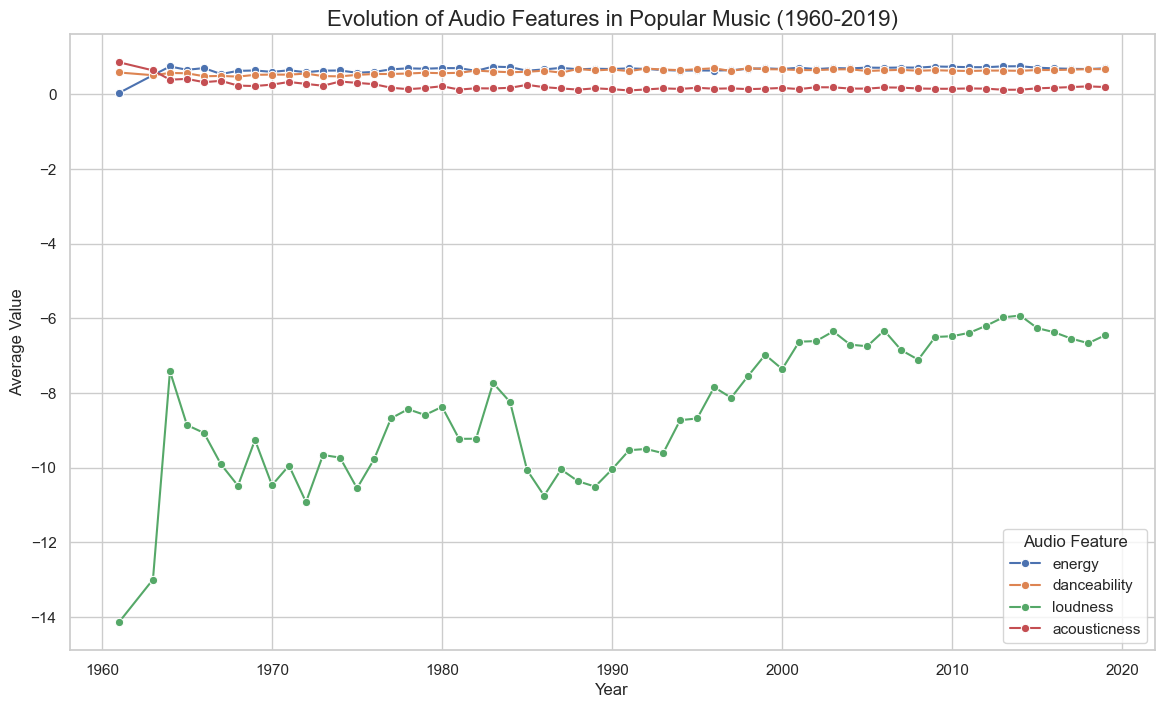

In [ ]:
# Group by year and calculate the mean of key audio features
yearly_trends = df.groupby('year')[['energy', 'danceability', 'loudness', 'acousticness']].mean()

# Focus on the era with more consistent data
yearly_trends_filtered = yearly_trends.query("index >= 1960 and index < 2020")

# Create the plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=yearly_trends_filtered, dashes=False, marker='o')
plt.title('Evolution of Audio Features in Popular Music (1960-2019)', fontsize=16)
plt.ylabel('Average Value')
plt.xlabel('Year')
plt.legend(title='Audio Feature')
plt.show()

### Making Trends Comparable with Normalization

In our previous trend plot, features like `loudness` (measured in negative dB) and `energy` (measured on a 0-1 scale) were plotted together. While this showed their individual trends, their vastly different scales made direct comparison difficult and could visually distort the magnitude of change.

To fix this, we can **normalize** the data. We will use **Min-Max Scaling**, a common technique that rescales every value in a column to a range between 0 and 1. This preserves the shape of each feature's distribution while putting them all on a common, comparable scale.

The formula is simple and intuitive:
$$
\text{Normalized Value} = \frac{\text{value} - \text{min}(\text{column})}{\text{max}(\text{column}) - \text{min}(\text{column})}
$$

By applying this, a song with the minimum loudness will have a normalized value of 0, the one with the maximum loudness will be 1, and all others will fall proportionally in between. This allows us to plot the *relative* change of each audio feature over time on the same axis, providing a much clearer picture of their evolution.

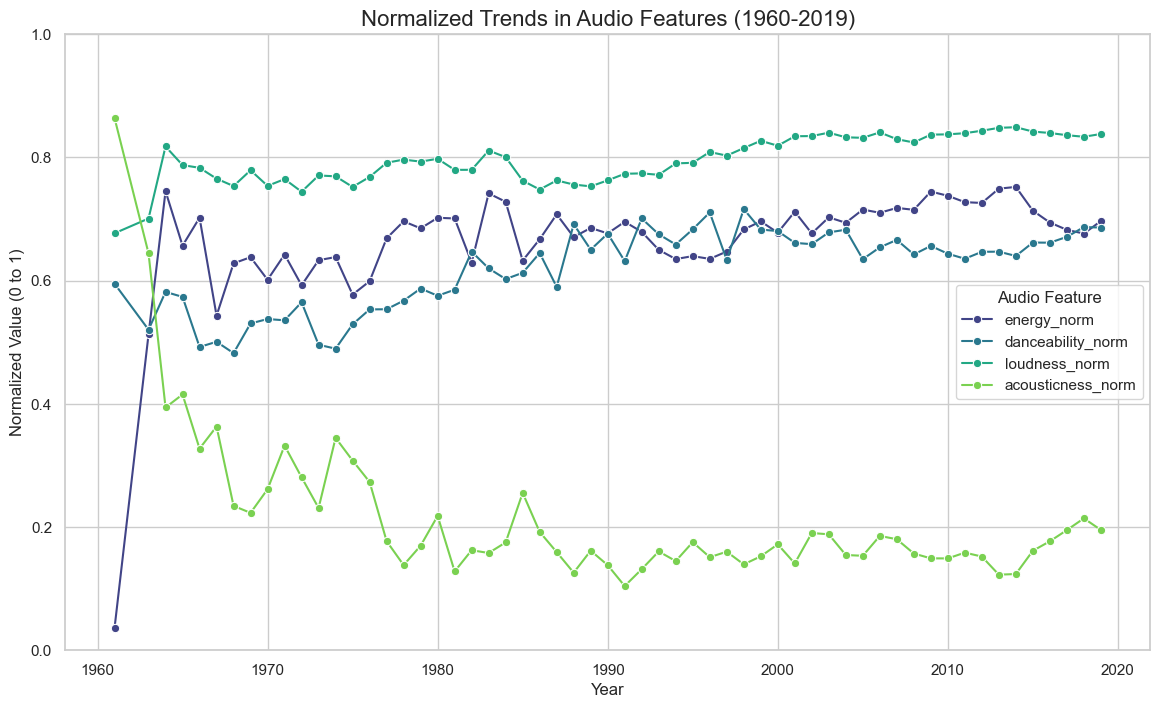

In [ ]:
# --- Step 1: Select columns and apply Min-Max Scaling ---
# Define the columns we want to put on a common scale
cols_to_normalize = ['energy', 'danceability', 'loudness', 'acousticness']

# Apply the Min-Max formula in a single vectorized operation for efficiency
# This is much faster than looping through each column individually
normalized_data = (df[cols_to_normalize] - df[cols_to_normalize].min()) / (df[cols_to_normalize].max() - df[cols_to_normalize].min())

# Create new column names for our normalized data
df[[f'{c}_norm' for c in cols_to_normalize]] = normalized_data


# --- Step 2: Re-run the Trend Analysis on Normalized Data ---
# Select the new normalized columns for our analysis
normalized_cols = [f'{c}_norm' for c in cols_to_normalize]

# Group by year and calculate the mean of the NORMALIZED features
yearly_trends_normalized = df.groupby('year')[normalized_cols].mean()

# Filter for the relevant era
yearly_trends_filtered_norm = yearly_trends_normalized.query("index >= 1960 and index < 2020")


# --- Step 3: Plot the Normalized Trends ---
plt.figure(figsize=(14, 8))
sns.lineplot(data=yearly_trends_filtered_norm, dashes=False, marker='o', palette='viridis')
plt.title('Normalized Trends in Audio Features (1960-2019)', fontsize=16)
plt.ylabel('Normalized Value (0 to 1)')
plt.xlabel('Year')
plt.legend(title='Audio Feature')
plt.ylim(0, 1) # Set y-axis to the full 0-1 range for clarity
plt.show()

## 4.2 Correlation Analysis with a Heatmap

What is the underlying structure of a song? A correlation heatmap reveals which features tend to move together.

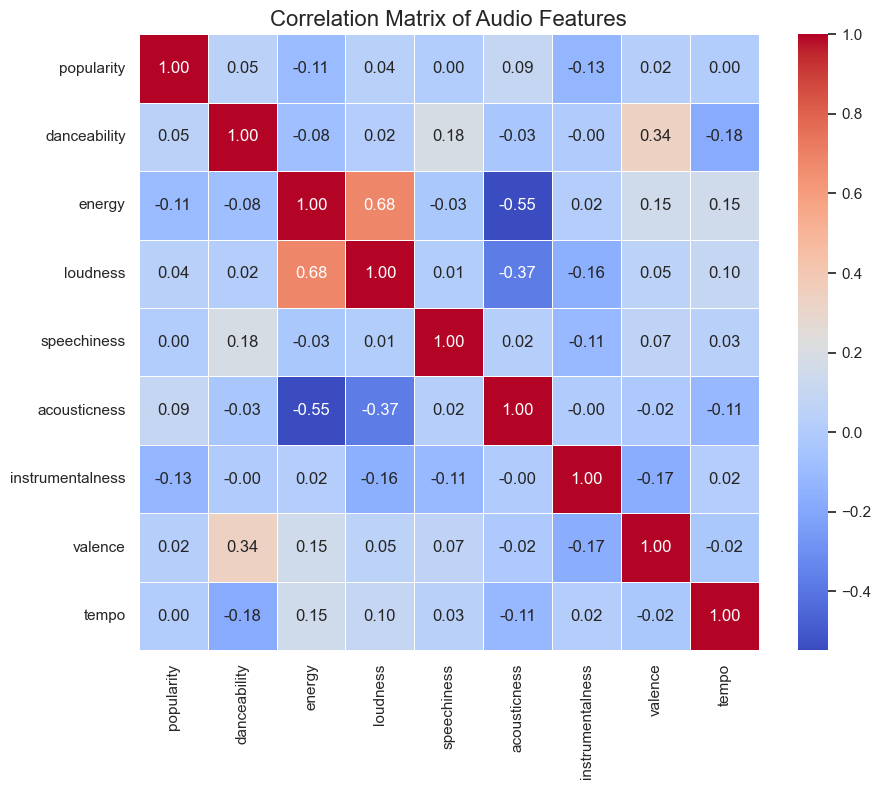

In [ ]:
audio_features = df[['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']]
corr_matrix = audio_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Audio Features', fontsize=16)
plt.show()

**Interpretation:** `energy` and `loudness` are strongly correlated (0.68), confirming our intuition. `acousticness` and `energy` are strongly negatively correlated (-0.55). Crucially, `popularity` has no strong linear correlation with any single audio feature. This suggests there is **no simple formula for a hit song**; it's a complex interplay of factors, not just "more danceable" or "more energetic."

## 🚀 Final Challenge: Music Evolution Project

**Central Question:** "How did popular music evolve from 2010 to 2019, and what makes a song a hit?"

Your task is to create a new notebook to conduct a comprehensive analysis answering this question.

### Your Analysis Must Include These Specific Tasks:

1.  **Temporal Trend Analysis:**
    *   Calculate and plot the 3-year rolling average for `acousticness` and `valence` for the 2010-2019 period. Use `.rolling(window=3).mean()`. Does this smoothed view confirm the trends we saw earlier?

2.  **Genre Market Share:**
    *   Use `pd.crosstab()` to create a frequency table of `genre` counts per `year` for 2010-2019.
    *   Normalize this table by row (`normalize='index'`) to show the percentage market share of each genre for each year.
    *   Which genre saw the biggest increase in market share over the decade?

3.  **Artist Sonic Diversity:**
    *   Using the `energy_vs_artist_avg` feature you created, find which `primary_artist` (with at least 10 songs in the dataset) has the most sonically diverse catalog. (Hint: Group by `primary_artist`, filter for `artist_song_count >= 10`, and find the one with the highest standard deviation (`.std()`) of `energy_vs_artist_avg`).

4.  **The "Hit Song" Profile:**
    *   Define a "hit" as any song with `popularity` in the top 15% (use the `.quantile(0.85)` method to find the threshold).
    *   Create a "is_hit" boolean column.
    *   Group by this `is_hit` column and calculate the mean of all key audio features. Present a table comparing the average "hit" song to the average "non-hit" song. What are the most significant differences?